In [49]:
from collections import defaultdict
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
import torch_geometric.utils as torch_util
import torch_scatter

from torch_geometric.data import DataLoader
from torch_geometric.datasets import MNISTSuperpixels, Planetoid, KarateClub
from torch_geometric.nn import ChebConv, GCNConv, SAGEConv

import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

%matplotlib inline

In [31]:
def load_mnist(slice_ratio, batch_size):
    path = '../../data/geometric/MNIST'
    
    trainset = MNISTSuperpixels(root=path, train=True)
    testset = MNISTSuperpixels(root=path, train=False)
    
    lenTrain= len(trainset)
    lenTest = len(testset)
    
    trainLoader = DataLoader(trainset[:lenTrain//slice_ratio], batch_size=batch_size, shuffle=False)
    testloader = DataLoader(testset[:lenTest//slice_ratio], batch_size=batch_size,  shuffle=False)
    
    return trainset, testset, trainLoader, testloader

def load_cora():
    path = '../../data/geometric/CORA'
    name = 'Cora'
    
    trainset = Planetoid(root=path, name=name)    
    trainLoader = DataLoader(trainset)
    
    return trainset, trainLoader

def load_karate():
    path = '../../data/geometric/KARATE'
    
    df = KarateClub
#     loader = DataLoader(df)
    
    return df

In [32]:
trainCORA, trainLoaderCORA = load_cora()

In [22]:
trainMNIST, testMNIST, trainLoaderMNIST, testloaderMNIST = load_mnist(1200, 32)

In [33]:
def get_adjacency(dataset):
    edgeList = np.array(dataset['edge_index'].transpose(1, 0))
    edgeList = list(map(tuple, edgeList))

    d = defaultdict(list)

    for k, v in edgeList:
        d[k].append(v)

    adj = nx.adjacency_matrix(nx.from_dict_of_lists(d))

    return adj

In [45]:
def split_edges(data, val_ratio=0.05, test_ratio=0.1):
    r"""Splits the edges of a :obj:`torch_geometric.data.Data` object
    into positve and negative train/val/test edges.

    Args:
        data (Data): The data object.
        val_ratio (float, optional): The ratio of positive validation
            edges. (default: :obj:`0.05`)
        test_ratio (float, optional): The ratio of positive test
            edges. (default: :obj:`0.1`)
    """

    assert 'batch' not in data  # No batch-mode.

    row, col = data.edge_index

    # Return upper triangular portion.
    mask = row < col
    row, col = row[mask], col[mask]

    n_v = math.floor(val_ratio * row.size(0))
    n_t = math.floor(test_ratio * row.size(0))

    # Positive edges.
    perm = torch.randperm(row.size(0))
    row, col = row[perm], col[perm]

    r, c = row[:n_v], col[:n_v]
    data.val_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v:n_v + n_t], col[n_v:n_v + n_t]
    data.test_pos_edge_index = torch.stack([r, c], dim=0)
    r, c = row[n_v + n_t:], col[n_v + n_t:]
    data.train_pos_edge_index = torch.stack([r, c], dim=0)

    # Negative edges.
    num_nodes = data.num_nodes
    neg_adj_mask = torch.ones(num_nodes, num_nodes, dtype=torch.uint8)
    neg_adj_mask = neg_adj_mask.triu(diagonal=1)
    neg_adj_mask[row, col] = 0

    neg_row, neg_col = neg_adj_mask.nonzero().t()
    perm = torch.tensor(random.sample(range(neg_row.size(0)), n_v + n_t))
    perm = perm.to(torch.long)
    neg_row, neg_col = neg_row[perm], neg_col[perm]

    neg_adj_mask[neg_row, neg_col] = 0
    data.train_neg_adj_mask = neg_adj_mask

    row, col = neg_row[:n_v], neg_col[:n_v]
    data.val_neg_edge_index = torch.stack([row, col], dim=0)

    row, col = neg_row[n_v:n_v + n_t], neg_col[n_v:n_v + n_t]
    data.test_neg_edge_index = torch.stack([row, col], dim=0)

    return data

In [46]:
print(len(trainCORA))
print(len(trainMNIST))

print(trainCORA[0])
print(trainMNIST[0])

adjCORA = get_adjacency(trainCORA[0]).toarray(int)
adjMNIST = get_adjacency(trainMNIST[0]).toarray(int)

print(adjCORA.shape, adjMNIST.shape)

1
60000
Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Data(edge_index=[2, 1399], pos=[75, 2], x=[75, 1], y=[1])


In [52]:
splitCORA = split_edges(data=trainCORA[0])
splitMNIST = split_edges(data=trainMNIST[0])

In [61]:
print((75**2)*60000, 2708**2)

337500000 7333264


In [21]:
row = train[0]

print(row, '\n')
print(np.array(row['edge_index'].transpose(1,0 )), '\n')
print(row['x'].shape, '\n')
print(row['pos'], '\n')
print(row['pos'].shape)

print(train.num_features)
print(train.num_classes)

# print(row['train_mask'], '\n')
# print(row['test_mask'], '\n')
# train[train.train_mask]

print(len(train), len(test))

# for step, batch in enumerate(train):
#     x = batch['x']
#     adj = batch['edge_index']

#     print(x.shape, type(x))
#     print(adj.shape, type(adj))
#     print(adj)
#     break

Data(edge_index=[2, 1399], pos=[75, 2], x=[75, 1], y=[1]) 

[[ 0  3]
 [ 0  8]
 [ 0 10]
 ...
 [74 55]
 [74 63]
 [74 69]] 

torch.Size([75, 1]) 

tensor([[20.9464,  5.0288],
        [13.3571, 18.1538],
        [ 7.1825,  6.4872],
        [16.0714,  4.6538],
        [ 9.0714,  8.1538],
        [ 7.0714, 21.9538],
        [10.3214,  5.6538],
        [ 4.2143, 22.4396],
        [12.9464,  7.0288],
        [10.2143, 22.2967],
        [18.5714,  5.1538],
        [16.5714, 13.1538],
        [12.7857, 11.7253],
        [11.2381,  9.3205],
        [11.0714, 11.6538],
        [18.2143, 16.7253],
        [14.8214, 20.4038],
        [11.8492, 20.0427],
        [14.0714, 13.8681],
        [13.0714,  4.6538],
        [15.9464, 18.2788],
        [15.7857,  7.0110],
        [10.0714, 10.6538],
        [ 9.2381, 19.9872],
        [16.2381, 15.3205],
        [ 8.1548, 11.5705],
        [24.6504, 24.2591],
        [20.0048,  0.2872],
        [ 6.5714, 25.1538],
        [10.2714,  2.8205],
        [ 4.0714

In [18]:
row = train[1000]

positions = row['pos'].numpy()
posDict = {i: positions[i] for i in range(len(row['pos']))}

edgeList = np.array(row['edge_index'].transpose(1,0 ))
x = nx.from_edgelist(edgeList)
x.add_nodes_from(posDict.keys())

C:\Users\lexokan\Anaconda3\envs\lab\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


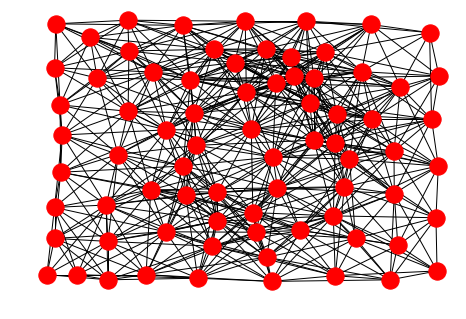

tensor([0])


In [19]:
nx.draw(x, posDict)
plt.show()

print(row['y'])

In [119]:
# edgeList = np.array(train[0]['edge_index'].transpose(1,0 ))
# graph = nx.from_edgelist(edgeList)
# # np.random.seed(0)
# plt.figure(figsize=(20, 20))

# nx.draw_networkx(graph)
# plt.draw() 

In [120]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(train.num_features, 16)
        self.conv2 = GCNConv(16, train.num_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training= self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [121]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net().to(device)
# data = train[0].to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# model.train()
# for epoch in range(200):
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.nll_loss(out[data.train.mask], data.y[data.train_mask])
#     loss.backward()
#     optimizer.step()

# model.eval()
# _, pred = model(data).max(dim=1)
# correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
# acc = correct / data.test_mask.sum().item()
# print('Accuracy: {:.4f}'.format(acc))

In [ ]:
### Testing the feature mismatch error 
### Feed in position vector as features
### Getting the correct loss function for our model
### Utility of edge_list as a good representation vs adjacency matrix
### Step through vaeFinal.ipynb